## MITx 6.419x - Data Analysis: Statistical Modeling and Computation in Applications

# Module 4 - Time Series Analysis

In [7]:
# Loading modules 

import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from itertools import chain 

# Visualization tools

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
output_notebook()

# Modeling tools

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import scipy

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg

# Ignoring warnings

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

# The Mauna Loa $CO_2$ Concentration

In 1958, Charles David Keeling (1928-2005) from Scripps Instituion of Ocenography began recording carbon dioxide ($CO_2$) concentrations in the atmosphere at an observatory located at about 3,400 m altitude on the Mauna Loa Volcano on Hawaii Island. The location was chosen because it is not influenced by changing $CO_2$ levels due to the local vegetation and because prevailing wind patterns on this tropical island tend to bring well-mixed air to the site. While the recordings are made near a volcano (which tends to produce $CO_2$) wind patterns tend to blow the volcanic $CO_2$ away from the recording site. Air samples are taken several times a day, and concentrations have been observed using the same measuring method for over 60 years. In addition, samples are stored in flasks and periodically reanalyzed for calibration purposes. The observational study is now run by Ralph Keeling, Charle's son. The result is a data set with very few interruptions and very few inhomogeneities. It has been called the "most important data set in modern climate research."

The data set for this problem provides the concentration of $CO_2$ recorded at Mauna Loa for eah month starting March 1958. More description is provided in the data set file. We will be considwering only the $CO_2$ concentration given in column 5. The goal of the problem is to fit the data and understand its variations. You will encounter missing data points; part of the exervise is to deal with them appropriately.

Let $C_i$ be the average $CO_2$ concentration in month $i$ ($i$ = 1,2,..., counting from March 1958). We will look for a description of the form:

$$C_ i = F(t_ i) + P_ i + R_ i$$

where:

$F: t \mapsto F(t)$ accounts for the long-term trend.

$t_i$ is time at the middle of the $i$th month, measured in fractions of years after Jan 15, 1958.
$P_i$ is periodic in $i$ with a fixed period, accounting for the seasonal pattern.

$R_i$ is the remaining residual that accounts for all other influences.

The decomposition is meaningful only if the range of $F$ is much larger than the amplitude of the $P_i$ and this amplitude in turn is substantially larger than that of $R_i$.

You are required to split the data into training and test datasets - you can perform an 80:20 split. All model fitting should be done only on the training set and all the remaining data should be used for evaluation (for the purpose of model selection), i.e. prediction errors should be reportted with respect to the test set.

You may notice that there are some inhomogeneities in data and the $CO_2$ concentration at these points is recorded as -99.99. Before proceeesing, we must clean the data. One simple way to do this is to drop all missing values from the table. For the purpose of the problems below, use this simple method of dropping all the missing values. Other methods include forward filling-fill missing values with previous values, and interpolation.

Now, fit the training data to a simple linear model $F_1(t) \sim \alpha _0 + \alpha _1t$. Plot the data and the fit.

<b> What are the values of $\hat\alpha_0$ and $\hat\alpha _1$ ?</b>

In [8]:
# Loading data

df = pd.read_csv("data\CO2.csv", header=[0, 1, 2], comment='"')
df.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
,,,,,,adjusted,,adjusted fit,filled,adjusted filled
,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   (  Yr,     ,     )                         744 non-null    int64  
 1   ( Mn,    ,    )                            744 non-null    int64  
 2   (    Date,         ,    Excel)             744 non-null    int64  
 3   (      Date,           ,           )       744 non-null    float64
 4   (     CO2,         ,    [ppm])             744 non-null    float64
 5   (seasonally,   adjusted,     [ppm] )       744 non-null    float64
 6   (        fit,            ,       [ppm])    744 non-null    float64
 7   (  seasonally, adjusted fit,     [ppm])    744 non-null    float64
 8   (      CO2,    filled,        [ppm])       744 non-null    float64
 9   ( seasonally, adjusted filled,     [ppm])  744 non-null    float64
dtypes: float64(7), int64(3)
me

In [10]:
# Fixing column names

df.columns = [
    " ".join(
        [col[0].strip(),
         col[1].strip(),
         col[2].strip()]
    ).strip()
    for col in df.columns.values
]
df.columns

Index(['Yr', 'Mn', 'Date  Excel', 'Date', 'CO2  [ppm]',
       'seasonally adjusted [ppm]', 'fit  [ppm]',
       'seasonally adjusted fit [ppm]', 'CO2 filled [ppm]',
       'seasonally adjusted filled [ppm]'],
      dtype='object')

In [11]:
# Creating a copy of the dataframe and preparing data

co2 = df.copy()

In [12]:
# Selecting columns

co2 = co2[['Yr','Mn', 'CO2  [ppm]']]
co2.columns = ['Year', 'Month', 'CO2']
co2.head()

,Year,Month,CO2
0,1958,1,-99.99
1,1958,2,-99.99
2,1958,3,315.70
3,1958,4,317.45
4,1958,5,317.51


In [13]:
# Replacing -99.99 with NaN

co2['CO2'].replace(-99.99, np.nan, inplace=True)
co2.head()

,Year,Month,CO2
0,1958,1,NaN
1,1958,2,NaN
2,1958,3,315.70
3,1958,4,317.45
4,1958,5,317.51


In [14]:
# Creating a time index measured in the middle of the month starting from zero

co2['time'] = (co2.index.values + 0.5 / 12)
co2.head()

,Year,Month,CO2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,1.041667
2,1958,3,315.70,2.041667
3,1958,4,317.45,3.041667
4,1958,5,317.51,4.041667


In [15]:
# Checking for null values

co2[co2.CO2.isnull()]

,Year,Month,CO2,time
0,1958,1,NaN,0.041667
1,1958,2,NaN,1.041667
5,1958,6,NaN,5.041667
9,1958,10,NaN,9.041667
73,1964,2,NaN,73.041667
74,1964,3,NaN,74.041667
75,1964,4,NaN,75.041667
741,2019,10,NaN,741.041667
742,2019,11,NaN,742.041667
743,2019,12,NaN,743.041667


In [16]:
# Dropping missing values and reseting index

co2 = co2.dropna()
co2.reset_index(drop=True, inplace=True)

In [17]:
# Creating design matrix X from the time index

X = co2['time']
len(X)

734

In [18]:
# Creating labels from the co2 values

y = co2['CO2']
len(y)

734

In [19]:
# Splitting the data with 80:20 split 

train_size = int(len(X)*0.8) # training with the first values of the timeframe
test_size = len(X) - train_size # testing predictions with the last values of the timeframe

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

587 587
147 147


In [20]:
# Visualizing training data

p = figure(plot_width = 800, plot_height = 600, title = "Visualization of Training Data")
p.scatter(X_train,y_train,size=5, line_color="navy", fill_color="orange", fill_alpha=0.5)
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
show(p)

There appears to be a clear linearly increasing trend on the data.

In [21]:
# Fitting data to linear regression model

lr = LinearRegression().fit(np.array(X_train).reshape(-1,1), y_train)

In [22]:
# Model coefficients

lr_coefficients = [lr.coef_[0], lr.intercept_]
print("The linear model F(t) = " +str(lr_coefficients[0])+"*t + " +str(lr_coefficients[1])+" ")

The linear model F(t) = 0.11722426245179311*t + 309.0453845193237 


In [23]:
# Plotting linear fit of the model

lr_linear_fit = lr.predict(np.array(X_train).reshape(-1,1))

p = figure(plot_width=800, plot_height=600, title='Modeling with the Linear Model')
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, lr_linear_fit, line_color="orange", line_width=2.5, legend_label ="Linear Fit")
p.legend.location = "bottom_right"
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
show(p)


The linear line seems to fit quite well but not perfectly as we can by having a closer look at the beginning and at the end of the scatter points.

<b> Plot the residual error $R_{linear}(t)=C(t)-F_1(t)$. Report the root mean squared error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this model.</b>

In [24]:
# Predicting with test data

lr_predictions = lr.predict(np.array(X_test).reshape(-1,1))

p = figure(plot_width=800, plot_height=600, title = "Predicting with Linear Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, lr_predictions, line_color="orange", line_width=2.5, legend_label ="Linear Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

We notice that the model doesn't predict very well as the line is way outside the predicted data points.

In [25]:
# Plotting the residuals 

lr_residuals = y_train - lr_linear_fit
p = figure(plot_width=800, plot_height=600, title = "Residuals for Linear Model")
p.scatter(X_train, lr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "bottom_right"
show(p)

We notice a concave shape on the residuals that indicates that the model is not able to predict very well as the residuals are not scattered randomly around zero. The residuals show that they hide a pattern that hasn't been found yet with the model.

In [26]:
# Calculating the prediction errors RMSE and MAPE

rmse_linear = (mean_squared_error(y_test, lr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_linear))

mape_linear = mean_absolute_percentage_error(y_test, lr_predictions)
print("The MAPE on test data is " + str(mape_linear*100)) # as a percentage

The RMSE on test data is 10.641458521874668
The MAPE on test data is 2.4504549564431417


In the problems below, we will fit quadratic and cubic models to the data and compute again $\text {RMSE}$ and $\text {MAPE}$. We will then evaluate which of these models is the lowest degree model that still captures the trend of the data best sufficiently.

Now, fit the data to a quadratic model $F_2(t) \sim \beta _0 + \beta _1 t + \beta _2 t^2$.

<b> What are the values of $\hat\beta_0$, $\hat\beta_1$ and $\hat\beta_2$?</b>

In [27]:
# Fitting quadratic model

qr = make_pipeline(PolynomialFeatures(2),LinearRegression())
qr.fit(np.array(X_train).reshape(-1, 1), y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [28]:
# Quadratic model coefficients

qr_coefficients = [qr.named_steps.linearregression.coef_[-1], qr.named_steps.linearregression.coef_[-2], qr.named_steps.linearregression.intercept_]
print("The quadratic model F(t) = " +str(qr_coefficients[0])+"*t^2 + " +str(qr_coefficients[1])+"*t + " +str(qr_coefficients[2])+"")

The quadratic model F(t) = 8.41493034591782e-05*t^2 + 0.06691855529153154*t + 314.1312375143947


In [29]:
# Plotting quadratic fit of the model

qr_quadratic_fit = qr.predict(np.array(X_train).reshape(-1, 1))

p = figure(plot_width=800, plot_height=600, title = "Modeling with the Quadratic Model")
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, qr_quadratic_fit, line_color="orange", line_width=2.5, legend_label ="Quadratic Fit")
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

This time the fit is better also in the beginning and at the end which indicates this is a better model compared to the previous one in modeling the data.

<b> Plot the residual error $R_{quadratic}(t)=C(t)-F_2(t)$. Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for the quadratic model.</b>

In [30]:
# Predicting with test data

qr_predictions = qr.predict(np.array(X_test).reshape(-1,1))

p = figure(plot_width=800, plot_height=600, title = "Predicting with Quadratic Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, qr_predictions, line_color="orange", line_width=2.5, legend_label ="Quadratic Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

We see that the fit of the line is much better than what it was previously. 

In [31]:
# Plotting the residuals 

qr_residuals = y_train - qr_quadratic_fit
p = figure(plot_width=800, plot_height=600, title = "Residuals for Quadratic Model")
p.scatter(X_train, qr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "top_right"
show(p)

This time the residuals are scattered more randomly than previously around zero which indicates there isn't a systematic problem with the model.

In [32]:
# Calculating the prediction errors RMSE and MAPE

rmse_quadratic = (mean_squared_error(y_test, qr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_quadratic))

mape_quadratic = mean_absolute_percentage_error(y_test, qr_predictions)
print("The MAPE on test data is " + str(mape_quadratic*100)) # as a percentage

The RMSE on test data is 2.501332219489292
The MAPE on test data is 0.5320319129739824


Now, fit the data to a cubic model $F_3(t) \sim \gamma _0 + \gamma _1 t + \gamma _2 t^2 + \gamma _3 t^3$.

<b> What are the values of $\hat\gamma_0$, $\hat\gamma_1$, $\hat\gamma_2$ and $\hat\gamma_3$?</b>

In [33]:
# Fitting cubic model

cr = make_pipeline(PolynomialFeatures(3),LinearRegression())
cr.fit(np.array(X_train).reshape(-1, 1), y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [34]:
# Cubic model coefficients

cr_coefficients = [cr.named_steps.linearregression.coef_[-1], cr.named_steps.linearregression.coef_[-2], cr.named_steps.linearregression.coef_[-3], cr.named_steps.linearregression.intercept_]
print("The cubic model F(t) = " +str(cr_coefficients[0])+"*t^3 + " +str(cr_coefficients[1])+"*t^2 + "+str(cr_coefficients[2])+"*t + " + str(cr_coefficients[3])+"")

The cubic model F(t) = -6.847418831031214e-08*t^3 + 0.00014544451047641054*t^2 + 0.052207984670826116*t + 314.882424255501


In [35]:
# Plotting cubic fit of the model

cr_cubic_fit = qr.predict(np.array(X_train).reshape(-1, 1))

p = figure(plot_width=800, plot_height=600, title = "Modeling with Cubic Model")
p.scatter(X_train, y_train, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Original Data")
p.line(X_train, cr_cubic_fit, line_color="orange", line_width=2.5, legend_label ="Cubic Fit")
p.xaxis.ticker = [0, 200, 400, 600]
p.xaxis.major_label_overrides = {0: '1958', 200: '1976', 400: '1992', 600: '2008'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

The fit seems to be quite good but we need to compare the residuals and the errors the model makes while predicting to the previous models in order to see which one performs the best.

<b> Plot the residual error $R_{cubic}(t)=C(t)-F_3(t)$. Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this model.</b>

In [36]:
# Predicting with test data

cr_predictions = cr.predict(np.array(X_test).reshape(-1,1))

p = figure(plot_width=800, plot_height=600, title = "Predicting with Cubic Model")
p.scatter(X_test, y_test, size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, cr_predictions, line_color="orange", line_width=2.5, legend_label ="Cubic Model Predictions")
p.xaxis.ticker = [620, 660, 700, 740]
p.xaxis.major_label_overrides = {620: '2010', 660: '2013', 700: '2016', 740: '2019'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "bottom_right"
show(p)

Although the model fit quite well with the training data once we try to predict we notice that the model does a worse job than the previous quadratic version.

In [37]:
# Plotting the residuals 

cr_residuals = y_train - cr_cubic_fit
p = figure(plot_width=800, plot_height=600, title = "Residuals for Cubic Model")
p.scatter(X_train, cr_residuals ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="Residuals")

p.yaxis.axis_label ='Residual'
p.legend.location = "top_right"
show(p)

The residuals show a random scattering around zero which indicates that there isn't a systematic problem with the model.

In [38]:
# Calculating the prediction errors RMSE and MAPE

rmse_cubic = (mean_squared_error(y_test, cr_predictions, squared=False))
print("The RMSE on test data is " + str(rmse_cubic))

mape_cubic = mean_absolute_percentage_error(y_test, cr_predictions)
print("The MAPE on test data is " + str(mape_cubic*100)) # as a percentage

The RMSE on test data is 4.1493707118117475
The MAPE on test data is 0.8483502723214033


Based on the predictions and analysing the results of the residuals and errors we notice that the best model to represent the data is the quadratic model which has no systematic trend in its residuals and which has the lowest $RMSE$ and $MAPE$ on predicting the test data.

Consider $F_n(t)$ to tbe the polynomial trend chosen in the last problem as sufficient to represent the trend in the data. We will now extract the periodic component which appears in the data.

First, remove the deterministic trend $F_n(t)$ from the time series and compute the average residual $C_i - F_n(t_i)$ for each month. Namely, collect all the residuals (from removing deterministic trend) for Jan (resp. Feb, Marc, etc) and average them to get one data point for Jan (resp. Feb, Mar, etc). The collection of these points can be interpolated for a periodic signal $P_i$.

<b> Report the values of the periodic signal $P_i$ for the month of January and February.</b>

In [39]:
# Removing deterministic trend from the time series

co2_train = co2.iloc[0:train_size,:].copy()
co2_test = co2.iloc[train_size:,:].copy()

co2_train['Quadratic Residuals'] = y_train - qr_quadratic_fit
print(co2_train.shape, co2_test.shape)
co2_train.head()

(587, 5) (147, 4)


,Year,Month,CO2,time,Quadratic Residuals
0,1958,3,315.70,2.041667,1.431786
1,1958,4,317.45,3.041667,3.114440
2,1958,5,317.51,4.041667,3.106925
3,1958,7,315.86,6.041667,1.321391
4,1958,8,314.93,7.041667,0.323372


In [40]:
# Grouping the residuals by month with the average over all months in the training set

monthly_residuals = co2_train.groupby('Month')['Quadratic Residuals'].mean()
monthly_residuals

Month
1    -0.012919
2     0.646407
3     1.355569
4     2.561858
5     2.982891
6     2.316473
7     0.776297
8    -1.301213
9    -3.128074
10   -3.309520
11   -2.081487
12   -0.921507
Name: Quadratic Residuals, dtype: float64

In [41]:
print('The periodic signal for the month of January is', monthly_residuals.values[0])
print('The periodic signal for the month of February is', monthly_residuals.values[1])

The periodic signal for the month of January is -0.01291921890639728
The periodic signal for the month of February is 0.646406596528737


There seems to be a clear seasonal component that should be added to the model in order to predict the change in $CO_2$, so based on this, we can try to build one final model where we include the periodic signal together with the quadratic model. 

We build the model by interpolating the periodic signal and then adding the quadratic component to predict the test data and see again from the residuals and prediction errors how the model performs compared to the previous ones.

<b> Plot the periodic signal $P_i$. Clearly state the definition the $P_i$, and make sure your plot is clearly labeled</b>

In [42]:
# Interpolating the months with the 1D interpolate function to get a continuous signal

periodic_signal = scipy.interpolate.interp1d(monthly_residuals.index, monthly_residuals.values, kind='cubic')

In [43]:
# Plotting the periodic signal

months = np.linspace(1, 12, num=100) # periodic_signal function uses this range to find the new values

p = figure(plot_width=800, plot_height=600, title='Periodic Signal')
p.scatter(monthly_residuals.index, monthly_residuals.values, size=6, line_color="orange", fill_color="navy", fill_alpha=1, legend_label ='Periodic Values')
p.line(months, periodic_signal(months), line_color="orange", line_width =2.5, legend_label ='Periodic Signal')
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
show(p)

We can see from the plot the periodic signal which is the average over all the months within the traininig data. The maximum of the signal occurs in May and minimum from September till October.

<b> Plot the final fit $F_n(t_i) + P_i$. Your plot should clearly show the final model on top of the entire time series, while indicating the split between the training and testing data.</b>

In [44]:
# Creating periodic signal for training and test sets by chaining the monthly residuals

periodic_train = list(chain.from_iterable(monthly_residuals[co2_train.Month].values[..., None])) 
periodic_test = list(chain.from_iterable(monthly_residuals[co2_test.Month].values[..., None]))
print(len(periodic_train))
print(len(periodic_test))

587
147


In [45]:
# Plotting the periodic signal with the quadratic model 

final_test = qr_predictions + periodic_test 

p = figure(plot_width=800, plot_height=600, title = "CO2 Variation with time")
p.scatter(X_train, y_train, size=2, line_color="black", fill_color="green", fill_alpha=0.5, legend_label ="Training Data")
p.line(X_train, qr_quadratic_fit + periodic_train, line_color="orange", line_width=2.5, legend_label ="Final Model (Training Data Fit)")
p.scatter(X_test, y_test, size=2, line_color="olive", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p.line(X_test, final_test, line_color="orangered", line_width=2.5, legend_label ="Final Model Predictions")
p.xaxis.ticker = [0, 146, 293, 440, 587, 734]
p.xaxis.major_label_overrides = {0: '1958', 146: '1971', 293: '1983', 440: '1995', 587: '2007', 734: '2019'}
p.xaxis.axis_label ='Time'
p.legend.location = "bottom_right"
show(p)

The figure shows the history of the increase of atmospheric carbon dioxide concentrations measured at Mauna Loa, Hawaii since 1958, and the predicted trajectory afterwards. The final model with the seasonal component included seems to fit quite well to the data which indicates that there is a clear seasonal component that is related to the increase and decrease of carbon dioxide levels.

<b> Report the root mean squared prediction error $\text {RMSE}$ and the mean absolute percentage error $\text {MAPE}$ with respect to the test set for this final model. Is this an improvement over the previous model $F_n(t_i)$ without the periodic signal?</b>

In [46]:
# Calculating the prediction errors RMSE and MAPE

rmse_final = (mean_squared_error(y_test, final_test, squared=False))
print("The mean squared prediction error of the final model is " + str(rmse_final))

mape_final = mean_absolute_percentage_error(y_test, final_test)
print("The mean absolute percentage error of the quadratic model is " + str(mape_final*100)) # as a percentage

The mean squared prediction error of the final model is 1.1493602690783542
The mean absolute percentage error of the quadratic model is 0.2085916594797079


The prediction error has decreased by adding the periodic signal component to the model which shows that there is an improvement over the previous quadratic model alone.

<b> What is the ratio of the range of values of $F$ to the amplitude of $P_i$ and the ratio of the amplitude of $P$ to the range of the residual $R_i$ (from removing both the trend and the periodic signal)?</b>

In [47]:
# Computing stats from the three different components of the model

print ("Amplitude of Trend: ")
Amp_trend = qr_quadratic_fit.max() - qr_quadratic_fit.min()
print(Amp_trend)

print ("\nAmplitude of Periodic Signal: ")
Amp_p = max(periodic_train) - min(periodic_train)
print(Amp_p)

print ("\nAmplitude of Residuals: ")
Amp_res = (y_train - qr_quadratic_fit - periodic_train).max() - (y_train - qr_quadratic_fit - periodic_train).min()
print(Amp_res)

print ("\nRatio of amplitudes of Trend to Periodic Signal: ")
print(Amp_trend / Amp_p)

print ("\nRatio of amplitudes of Periodic Signal  to Residuals: ")
print(Amp_p / Amp_res)

Amplitude of Trend: 
69.14369234539322

Amplitude of Periodic Signal: 
6.292410667159611

Amplitude of Residuals: 
3.8363992375799665

Ratio of amplitudes of Trend to Periodic Signal: 
10.98842653520016

Ratio of amplitudes of Periodic Signal  to Residuals: 
1.6401866118420245


The amplitude or the range of the trend $F$ is large compared to that of the periodic signal $P_i$ which itself is larger compared to range of the residuals $R_i$.

This makes sense as the quadratic (i.e. long-term) trend component explains the bulk of the increase of $CO_2$ while the seasonal component also contributes to this increase, but not as much as the long-term trend. The unexplained residual compotent is what is left unexplained by the model, and it should be as small as possible which is the case when we include the seasonal periodic signal to the model. The decomposition of the model into a long-term trend and a seasonal component is thus meaningful.

# BPP Data Analysis

The goal of this problem is to analyze the PriceStats data from the MIT Billion Prices Project (www.thebillionpricesproject.com), provided by Professor Rigobon. In addition, the file PriceStats_CPI.csv also contains a column $\text {CPI}$. The $\text {CPI}$ (consumer price index, the price of a "market basket of consumer goods and services" - a proxy for inflation) is released monthly by the Bureau of Labor Statistics. The file T10YIE.csv lists (during most the same time period) the break-even rate ($\text {BER}$), or the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. The difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average.

There is more than a decade of data in PriceStats_CPI.csv. For your results to the probles below, report the mean squared prediction error for 1 month ahead forecasts starting September 2013. For example, to predict the $\text {CPI}$ in May 2015, you can use all the data before May 2015. You should perform all of your model fitting on the months prior to September 2013, and use the remaining months for evaluation.

Additional References:

    - The Consumer Price Index (CPI) is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. To read more, visit https://www.bls.gov/cpi.
    
    - As explained in the question above, BER is the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average. To read more, visit http://www.bondeconomics.com/2014/05/primer-what-is-breakeven-inflation.html.
    
    - Developed as a part of MIT Billion Prices Project, PriceStats collects price information from over 1,000 retailers across more than 50 countries and publishes the daily inflation series for over 20 countries. (It is akin to CPI in terms of units.) To read more, visit https://wwww.pricestats.com/.

<b> First, we will try to predict the monthly  $\text {CPI}$ without using $\text {BER}$ or PriceStats.</b>

<b> Plot the monthly CPI value as a time series (e.g. take the first CPI value of each month as that month's CPI). What is the most obvious trend that you can observe in the data?</b>

In [48]:
# Loading data and parsing dates to datetime

cpi = pd.read_csv('data\PriceStats_CPI.csv', parse_dates=['date'])
cpi.head()

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0
1,2008-07-25,99.99767,100.0
2,2008-07-26,99.92376,100.0
3,2008-07-27,99.91537,100.0
4,2008-07-28,99.89491,100.0


In [49]:
# Creating monthly value per year for CPI

cpi['YearMonth'] = cpi.date.dt.strftime('%Y-%m')
cpi.head()

,date,PriceStats,CPI,YearMonth
0,2008-07-24,100.00000,100.0,2008-07
1,2008-07-25,99.99767,100.0,2008-07
2,2008-07-26,99.92376,100.0,2008-07
3,2008-07-27,99.91537,100.0,2008-07
4,2008-07-28,99.89491,100.0,2008-07


In [50]:
# Dropping duplicates and resetting index

cpi = cpi.drop_duplicates('YearMonth', keep='last').reset_index()
cpi.head()

,index,date,PriceStats,CPI,YearMonth
0,7,2008-07-31,99.86741,100.00000,2008-07
1,38,2008-08-31,99.65405,100.52510,2008-08
2,68,2008-09-30,99.70792,100.12380,2008-09
3,99,2008-10-31,97.98654,99.98538,2008-10
4,129,2008-11-30,96.55315,98.97539,2008-11


In [51]:
# Splitting data into training and test sets according to instructions

cpi_train = cpi[cpi.YearMonth<'2013-09'].copy()
cpi_test = cpi[cpi.YearMonth>='2013-09'].copy()
cpi_train.shape, cpi_test.shape

((62, 5), (75, 5))

In [52]:
# Plotting CPI

p = figure(plot_width=800, plot_height=600, title="Monthly CPI")
p.line(cpi_train.index, cpi_train.CPI, line_color="navy", line_width=2.5)
p.xaxis.ticker = [0, 6, 18, 30, 42, 54]
p.xaxis.major_label_overrides = {0: '2008', 6: '2009', 18: '2010', 30: '2011', 42: '2012', 54: '2013'}
p.xaxis.axis_label='Time'
p.yaxis.axis_label='CPI'
show(p)

From the plot we can clearly see an upward sloping linear trend which makes the time series non-stationary.

We will now detrend this data into $CPI_ t = T_ t +R_ t$. Below, we fit a linear trend to the training data. (You could also experiment with a different way of detrending.).

Fit a linear trend $T_t$ to the training data:

$$T_t =\alpha_1t+\alpha_0.$$

<b> Verify your result by plotting the linear trend on top of the data. Report $\alpha_1$ and $\alpha_0$</b>

In [53]:
# Fitting linear model

lr = LinearRegression().fit(np.array(cpi_train.index).reshape(-1, 1), cpi_train.CPI)

In [54]:
# Linear model coefficients

lr_coefficients = [lr.coef_[0], lr.intercept_]
print("The linear trend is given by F(t) = " +str(lr_coefficients[0])+"*t + " +str(lr_coefficients[1])+"")

The linear trend is given by F(t) = 0.16104348366951224*t + 96.72932632872502


In [55]:
# Plotting linear trend on top of the data

linear_fit = lr.predict(np.array(cpi_train.index).reshape(-1, 1))

p = figure(plot_width=800, plot_height=600, title="Modeling CPI with the Linear Model")
p.line(cpi_train.index, cpi_train.CPI, line_color="navy", line_width=2, legend_label ="Original Data")
p.line(cpi_train.index, linear_fit, line_color="orange", line_width=2.5, legend_label ="Linear Trend")
p.xaxis.ticker = [0, 6, 18, 30, 42, 54]
p.xaxis.major_label_overrides = {0: '2008', 6: '2009', 18: '2010', 30: '2011', 42: '2012', 54: '2013'}
p.xaxis.axis_label='Time'
p.yaxis.axis_label='CPI'
p.legend.location='bottom_right'
show(p)

<b> Subtract the linear trend from the data to get the residuals $R_t$. Visualize $R_t$. Do you see obvious further trend or seasonality in $R_t$? Report the maximum absolute value of the residuals over the training data.</b>

In [56]:
# Plotting detrended data by removing the linear trend from data

detrend = cpi_train.CPI - linear_fit

p = figure(plot_width=800, plot_height=600, title = "CPI Detrended Time Series")
p.line(cpi_train.index, detrend, line_color="navy", line_width=2, legend_label ="Detrended Data")
p.xaxis.ticker = [0, 6, 18, 30, 42, 54]
p.xaxis.major_label_overrides = {0: '2008', 6: '2009', 18: '2010', 30: '2011', 42: '2012', 54: '2013'}
p.legend.location='bottom_right'
show(p)

In [57]:
print("The maximum absolute value of the residuals value is", abs(np.max(detrend)))

The maximum absolute value of the residuals value is 3.634730187605456


In [58]:
# Plotting another way to detrend the data with logarithmic differencing

cpi_diff_log = np.log(cpi.CPI).diff()
detrend_diff = cpi_diff_log[0:cpi_train.shape[0]]

p = figure(plot_width=800, plot_height=600, title="CPI Detrended with Differencing")
p.line(cpi_train.index, detrend_diff, line_color="navy", line_width=2, legend_label="Detrended Data with Differencing")
p.xaxis.ticker = [0, 6, 18, 30, 42, 54]
p.xaxis.major_label_overrides = {0: '2008', 6: '2009', 18: '2010', 30: '2011', 42: '2012', 54: '2013'}
p.legend.location = "bottom_right"
show(p)

In [59]:
print("The maximum absolute value of the residuals value is", abs(np.max(detrend_diff)))

The maximum absolute value of the residuals value is 0.00970362686099957


Both methods work as they manage to remove the trend from the data, however the logarithmic differencing has a lower maximum absolute value of the residuals which could indicate it achieves better results.

As there seems to be no other clear trend present in this residual, we can take the linear trend to be sufficient and move to the next step, i.e. to deseasonalize the data. However, since the visualization of the residual also seems to indicate no clear seasonality, we directly proceed to fitting an AR Model on the residual $R_t$.

<b>Determine the order $p$ of the AR model by examining the auto-correlation and partial auto-correlation functions of the residuals. Start with a single AR term and add terms as necessary.</b>

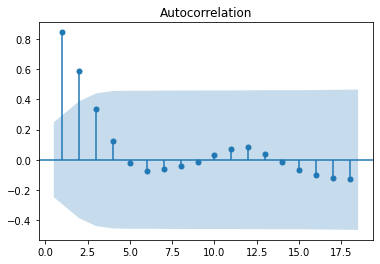

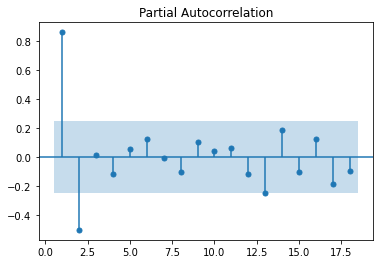

In [60]:
# Plotting Auto-correlation and partial auto-correlation functions of the residuals

plot_acf(detrend, zero=False)
plot_pacf(detrend, zero=False)
plt.show()

We notice from both plots that the highest lag where the autocorrelation extends beyond the statistically significant boundary (i.e. blue frame) is at lag 2. This would indicate that we could model the CPI data with an AR(2) model. We can confirm this by calculating the RMSE of the fit with different lags.

In [61]:
# Plotting RMSE for a range of lags p with detrended data

n = 2
rmse_ar=[]

cpi_diff_log = np.log(cpi.CPI).diff() # Detrending the data with differencing
remaining = cpi_diff_log[0:cpi_train.shape[0]] # Taking only the training set
remaining.iloc[0] = 0  

remaining_test = cpi_diff_log[cpi_train.shape[0]:].dropna()
remaining_test.iloc[0] = 0

for n in range(1,8):
    model = AutoReg(remaining, lags=n)
    model_fit = model.fit()
    coef = model_fit.params
    past = remaining[len(remaining)-n:].values
    past = [past[i] for i in range(len(past))]    
    test_predictions = list()
    
    for t in range(len(remaining_test.dropna())):
        length = len(past)
        lag = [past[i] for i in range(length-n, length)]
        pred = coef[0]
        
        for d in range(n):
            pred += coef[d+1] * lag[n-d-1]
        obs = remaining_test.values[t]
        test_predictions.append(pred)
        past.append(obs)
    
    rmse = (mean_squared_error(remaining_test.dropna(), test_predictions))**0.5
    rmse_ar.append(rmse)
    
    print('Test RMSE for AR(' + str(n) +'):' + str(rmse))

p = figure(plot_width=800, plot_height=600, title="RMSE of AR Models of order n")
p.scatter(np.arange(1,8), rmse_ar, size = 15, marker="square", line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label="RMSE")
p.xaxis.axis_label ='Number of Lags'
#p.yaxis.axis_label ='RMSE'
p.legend.location='bottom_right'
show(p)

Test RMSE for AR(1):0.0023953848786495316
Test RMSE for AR(2):0.0023342073865404603
Test RMSE for AR(3):0.002336359955382079
Test RMSE for AR(4):0.002390227562898291
Test RMSE for AR(5):0.002350614596570656
Test RMSE for AR(6):0.002419240208308682
Test RMSE for AR(7):0.002497972567898628


The lowest RMSE comes with 2 lags which confirms the previous result.

Using the lag $p$ from the previous problem, fit an $\text {AR}(p)$ model to the training data. Recall from the lecture the $\text {AR}(p)$ model:

$$X_{t}=\phi _{1}X_{{t-1}}+\ldots +\phi _{p}X_{{t-p}}+\varepsilon _{t}.$$

<b> Report the coefficients $\phi_1$ and $\phi_2$. Plot the final predictions and the actual observed data together to visualize the fit.</b>

In [62]:
# Building and fitting the AR(2) model with linearly detrended fitting

n = 2

AR2_model = AutoReg(detrend, lags= n).fit()
coef = AR2_model.params

past = detrend[len(detrend)-n:].values
past = [past[i] for i in range(len(past))]

training_predictions = AR2_model.predict(start = cpi_train.index[0], end=cpi_train.index[-1])

test_predictions = list()
linear_fit_test = lr.predict(np.array(cpi_test.index).reshape(-1,1))
detrend_test = cpi_test.CPI - linear_fit_test

for t in range(len(detrend_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = detrend_test.values[t]
    test_predictions.append(pred)
    past.append(obs)

final_training = training_predictions + linear_fit
final_test = test_predictions + linear_fit_test

In [63]:
# AR(2) model coefficients for linearly detrended data

print("The AR(2) model X(t) = " +str(coef[1])+"*X_t-1 " +str(coef[2])+"*X_t-2 ", str(coef[0]) )

The AR(2) model X(t) = 1.323665527908049*X_t-1 -0.5307973982632423*X_t-2  -0.04310484527786574


In [64]:
# Plotting the AR2 linearly detrended model

p = figure(plot_width=800, plot_height=600, title = "CPI predictions")
p.line(cpi_train.index, cpi_train.CPI, line_width =2.5, line_color="black", line_dash="dashed", legend_label="Training Data")
p.line(cpi_test.index, cpi_test.CPI, line_width =2.5, line_color="green", line_dash="dashed", legend_label="Test Data")
p.line(cpi_train.index, final_training, line_color="red", line_width=2.5, legend_label="Final AR(2) Model (Training Data Fit)")
p.line(cpi_test.index, final_test, line_color="orange", line_width=2.5, legend_label="Final AR(2) Model Predictions")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.legend.location = "bottom_right"
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CPI'

show(p)

In [65]:
# Calculating Mean Squared Error for the AR(2) model

rmse = mean_squared_error(cpi_test.CPI.dropna(), final_test[:-2])**0.5
print("The RMSE of the final fit is " + str(rmse))

The RMSE of the final fit is 0.39328060138088855


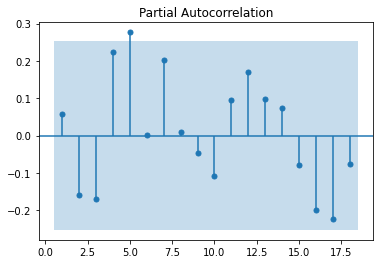

In [66]:
# Checking autocorrelation of residuals

residuals = (detrend - training_predictions)[2:]
plot_pacf(residuals, zero=False)
plt.show()

As we can see from the plot and the low score of RMSE, we get quite good results by substracting the linear trend from the data and using an AR model with 2 lags for predicting future values. The residuals also show no autocorrelation although one of the lags manages to reach out from the statistically significant threshold.

In [67]:
# Building AR(2) model with logarithmic differencing


def rebuild_diffed(series, first_element_original):
    cumsum = pd.Series(series).cumsum()
    final = np.exp(cumsum.fillna(0) + first_element_original)
    if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))
    return final


n = 2

AR2_model = AutoReg(remaining, lags= n).fit()
coef = AR2_model.params

past = remaining[len(remaining)-n:].values
past = [past[i] for i in range(len(past))]

training_predictions = AR2_model.predict(start = cpi_train.index[0], end=cpi_train.index[-1])

test_predictions = list()
cpi_diff_log = np.log(cpi.CPI).diff()
remaining_test = cpi_diff_log[cpi_train.shape[0]:].dropna()
remaining_test.iloc[0] = 0

for t in range(len(remaining_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n, length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = remaining_test.values[t]
    test_predictions.append(pred)
    past.append(obs)

final_training = (rebuild_diffed(training_predictions, np.log(cpi_train.CPI[0])))
final_test = (rebuild_diffed(test_predictions ,np.log(cpi_train.iloc[-1].CPI)))

In [68]:
#  AR(2) model coefficients for logarithmic differenced data

print("The AR(2) model X(t) = " +str(coef[1])+"*X_t-1 " +str(coef[2])+"*X_t-2 +", str(coef[0]) )

The AR(2) model X(t) = 0.6322745148155536*X_t-1 -0.22223215714534927*X_t-2 + 0.0005492609233792831


In [69]:
# Plotting the AR2 logarithmic differenced model

p = figure(plot_width=800, plot_height=600, title = "CPI predictions")
p.line(cpi_train.index, cpi_train.CPI, line_width =2.5, line_color="black", line_dash="dashed", legend_label="Training Data")
p.line(cpi_test.index, cpi_test.CPI, line_width =2.5, line_color="green", line_dash="dashed", legend_label="Test Data")
p.line(cpi_train.index, final_training, line_color="red", line_width=2.5, legend_label="Final AR(2) Model (Training Data Fit)")
p.line(cpi_test.index, final_test, line_color="orange", line_width=2.5, legend_label="Final AR(2) Model Predictions")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.legend.location = "bottom_right"
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='CPI'

show(p)

In [70]:
# Calculating Mean Squared Error for the AR(2) model with logarithmic differencing

rmse = mean_squared_error(cpi_test.CPI.dropna(), final_test[:])**0.5
print("The RMSE of the final fit with logarithmic differencing is " + str(rmse))

The RMSE of the final fit with logarithmic differencing is 0.862001125927233


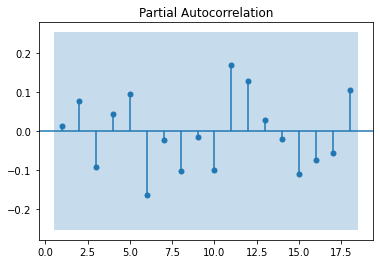

In [71]:
# Checking autocorrelation of residuals

residuals = (remaining - training_predictions)[2:]
plot_pacf(residuals, zero=False)
plt.show()

As we can see from the results, both ways to detrend the data - the linear detrending and logarithmic differencing - achieve pretty good results. However, if we compare the plots we can see that the logarithmic differencing method doesn't manage to produce a very accurate fitting in the beginning of the graph where we see a large dip of the inflation rate, as well as the small upswing at the end. The way the inflation is calculated by differencing also has an effect in producing a small gap where the training and test data meet in the center. On the other hand, when choosing to detrend the CPI data by substracting the linear trend, we achieve to follow the datapoints quite well during up- and downswings, as well as predicting the movements of inflation in the future. This method produces the best result which we can also notice from the smaller error term, RMSE.

# Inflation Rate from CPI

Note that $\text {CPI}$ is not a rate by itself while $\text {BER}$ is. In order to take the different data sets comparable and use them together, we must first transform the data. One way to do this is to calculate monthly inflation rates from the different data sets given to us:

How might you calculate monthly inflation rates from the $\text {CPI}$ data?

- The monthly inflation rate can be calculated as the percentage change of $\text {CPI}$ per month:

$$\text {IR}_ t = \frac{\text {CPI}_ t -\text {CPI}_{t-1}}{\text {CPI}_{t-1}}$$

where $t$ indexes the months.

<b> Plot the monthly inflation rate calculated by the formula above and report below the value for February, 2013.</b>

In [72]:
# Creating a function to calculate the monthly inflation rate

def calc_inflation_rate(data):
    ir = []
    for i in range(1, len(data)):
        ir_calc = (data[i] - data[i-1]) / data[i-1] * 100 # in percentage     
        ir.append(ir_calc)
    return ir

In [73]:
# Calculating monthly inflation rate from CPI

cpi.loc[1:, 'IR'] = calc_inflation_rate(cpi.CPI.values)
cpi.head()

,index,date,PriceStats,CPI,YearMonth,IR
0,7,2008-07-31,99.86741,100.00000,2008-07,NaN
1,38,2008-08-31,99.65405,100.52510,2008-08,0.525100
2,68,2008-09-30,99.70792,100.12380,2008-09,-0.399204
3,99,2008-10-31,97.98654,99.98538,2008-10,-0.138249
4,129,2008-11-30,96.55315,98.97539,2008-11,-1.010138


In [74]:
print("The inflation rate for the month of February in 2013 was %0.5f " % cpi[cpi.YearMonth =='2013-02']['IR'] +"%")

The inflation rate for the month of February in 2013 was 0.29572 %


In [75]:
# Plotting the monthy inflation rate IR

p = figure(plot_width=800, plot_height=600, title="Monthly IR from CPI (in %)")
p.line(cpi.index, cpi['IR'], line_color="orange", line_width =2.5)
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='Monthly IR'

show(p)

Another way to get the monthly inflation rate is to compute the difference of the logarithms:

$$\text {IR}_ t = \ln (\text {CPI}_ t) -\ln (\text {CPI}_{t-1})$$

where $t$ indexes the months.

<b> Plot the monthly inflation rate calculated by the formula above and report below the value for February, 2013.</b>

In [76]:
# Calculating the monthly inflation with the difference of the logarithms

cpi['Diff_Log'] = np.log(cpi.CPI).diff().values * 100
cpi.head()

,index,date,PriceStats,CPI,YearMonth,IR,Diff_Log
0,7,2008-07-31,99.86741,100.00000,2008-07,NaN,NaN
1,38,2008-08-31,99.65405,100.52510,2008-08,0.525100,0.523726
2,68,2008-09-30,99.70792,100.12380,2008-09,-0.399204,-0.400003
3,99,2008-10-31,97.98654,99.98538,2008-10,-0.138249,-0.138344
4,129,2008-11-30,96.55315,98.97539,2008-11,-1.010138,-1.015274


In [77]:
print("The inflation rate for the month of February in 2013 was %0.5f " % cpi[cpi.YearMonth =='2013-02']['Diff_Log'] + "%")

The inflation rate for the month of February in 2013 was 0.29529 %


In [78]:
# Plotting the monthy inflation rate log differenced IR 

p = figure(plot_width=800, plot_height=600, title="Monthly IR from CPI (in %)")
p.line(cpi.index, cpi['Diff_Log'], line_color="navy", line_width =2.5)
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='Monthly IR'

show(p)

# Inflation Rate from PriceStats

How about from Price Stats data? Note that PriceStats data is reported on a daily basis and there may be multiple ways to calculate a "monthly" inflation rate. For the methods described below, report the monthly inflation rate calculated using PriceStats data for February, 2013.

Method I: Compute the monthly inflation rate as the percentage change of $\text {PriceStats}$ per month using a representative value of $\text {PriceStats}$
    
$$\text {IR}_{m} = \frac{\text {PriceStats}_ m -\text {PriceStats}_{m-1}}{\text {PriceStats}_{m-1}}$$
   
where $m$ indexes the months, and $\text {PriceStats}_m$ is a representative value of $\text {PriceStats}$ of the month $m$.
    
<b> There are different monthly representatives we can choose. Plot the monthly inflation rate calculated by the formula above and the following representative values of $\text {PriceStats}$ of the month $m$. Report the value for February, 2013 using the average $\text {PriceStats}$ value of all days in a month $m$ and using the $\text {PriceStats}$ value of the last day of month $m$.</b>

In [79]:
# Loading and preparing dataset

pricestats = pd.read_csv('data\PriceStats_CPI.csv', parse_dates=['date'])
pricestats.head()

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0
1,2008-07-25,99.99767,100.0
2,2008-07-26,99.92376,100.0
3,2008-07-27,99.91537,100.0
4,2008-07-28,99.89491,100.0


In [80]:
# Extracting month and year together into series

pricestats['YearMonth'] = pricestats.date.dt.strftime('%Y-%m')
pricestats.head()

,date,PriceStats,CPI,YearMonth
0,2008-07-24,100.00000,100.0,2008-07
1,2008-07-25,99.99767,100.0,2008-07
2,2008-07-26,99.92376,100.0,2008-07
3,2008-07-27,99.91537,100.0,2008-07
4,2008-07-28,99.89491,100.0,2008-07


In [81]:
# Creating a new dataframe for monthly calculations

pricestats_monthly = pd.DataFrame(columns=['YearMonth','PriceStats_m','PriceStats_avg_rate'])
pricestats_monthly['PriceStats_m'] = pricestats.groupby('YearMonth')['PriceStats'].mean().values
pricestats_monthly.loc[1:, 'PriceStats_avg_rate'] = calc_inflation_rate(pricestats_monthly.PriceStats_m.values)
pricestats_monthly['YearMonth'] = cpi.YearMonth # taking the months from the cpi dataframe
pricestats_monthly.head()

,YearMonth,PriceStats_m,PriceStats_avg_rate
0,2008-07,99.921038,NaN
1,2008-08,99.727196,-0.193995
2,2008-09,99.770512,0.043435
3,2008-10,99.011287,-0.760972
4,2008-11,97.221704,-1.80745


In [82]:
print("The inflation rate using the average PriceStats value of all days in a month for February 2013 was %0.5f " % pricestats_monthly[pricestats_monthly.YearMonth == '2013-02']['PriceStats_avg_rate'] + "%")

The inflation rate using the average PriceStats value of all days in a month for February 2013 was 1.03587 %


In [83]:
# Creating a new column for calculating the inflation rate using the PriceStats value the last day of the month

pricestats_monthly.loc[1:, 'PriceStats_lastday_rate'] = calc_inflation_rate(cpi.PriceStats.values)
pricestats_monthly.head()

,YearMonth,PriceStats_m,PriceStats_avg_rate,PriceStats_lastday_rate
0,2008-07,99.921038,NaN,NaN
1,2008-08,99.727196,-0.193995,-0.213643
2,2008-09,99.770512,0.043435,0.054057
3,2008-10,99.011287,-0.760972,-1.726423
4,2008-11,97.221704,-1.80745,-1.462844


In [84]:
print("The inflation rate using the PriceStats value of the last day of month for February 2013 was %0.5f " % pricestats_monthly[pricestats_monthly.YearMonth == '2013-02']['PriceStats_lastday_rate'] + "%")

The inflation rate using the PriceStats value of the last day of month for February 2013 was 1.15945 %


Method II: Calculate daily inflation rates (i.e. the percentage change of $\text {PriceStats}$ per day). Then take the average of daily inflation rates across all days of the month to get a representative of the monthly inflation rate. Finally multiplication by 30 to change the units from per day to per month.

<b> Plot the monthly inflation rate for this method and report the value for February, 2013</b>

In [85]:
# Creating a new dataframe for daily calculations

pricestats_daily = pd.DataFrame(columns=['YearMonth', 'PriceStats_daily_rate'])

pricestats.loc[1:,'daily_values'] = calc_inflation_rate(pricestats.PriceStats.values)
pricestats_daily['PriceStats_daily_rate'] = pricestats.groupby('YearMonth')['daily_values'].mean().values * 30
pricestats_daily['YearMonth'] = cpi.YearMonth
pricestats_daily.head()

,YearMonth,PriceStats_daily_rate
0,2008-07,-0.568484
1,2008-08,-0.206947
2,2008-09,0.054266
3,2008-10,-1.684524
4,2008-11,-1.473188


In [86]:
print("The inflation rate from averaging daily rates from PriceStats for the month of February in 2013 was %0.5f" % pricestats_daily[pricestats_daily.YearMonth == '2013-02']['PriceStats_daily_rate'] + " %")

The inflation rate from averaging daily rates from PriceStats for the month of February in 2013 was 1.23551 %


In [87]:
# Plotting the monthly inflation rate from Pricestats calculated from the average across all days of the month

p = figure(plot_width=800, plot_height=600, title = "Monthly Inflation Rate in %")
p.line(pricestats_daily.index, pricestats_daily['PriceStats_daily_rate'], line_color="lightskyblue",line_width=2.5, legend_label ="PriceStats Average Daily")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='Monthly IR'
p.legend.location='bottom_right'

show(p)

# Inflation Rate from BER

BER data is not only reported on a daily basis but the values are calculated over a 10 year period. In order to use this data to get the "monthly" inflation rate one must:

    - Choose a representative value of BER for each month (e.g. the average or the value on the last day of the month);
    - "Deannualize" the monthly representatives above to convert to the monthly inflation rate. This deannualization of BER can be done by using the formula
    
$$\text {BER}^{\text {monthly}}_ t = (\text {BER}^{\text {yearly}}_ t +1)^\frac {1}{12} -1$$

where $t$ indexes the days.

<b> Use the average value of BER over each month as the monthly representative, and deannualize this value to find the monthly inflation rate. Report the monthly inflation rate for February, 2013</b>

In [88]:
# Loading and preparing the dataset

ber = pd.read_csv('data\T10YIE.csv', parse_dates=['DATE'])
ber.head()

,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71


We notice that the BER time series starts from January 2003 onwards instead of July 2008 like the CPI and PriceStats time series.

In [89]:
# Checking for null values

ber[ber.T10YIE.isnull()]

,DATE,T10YIE
12,2003-01-20,NaN
32,2003-02-17,NaN
76,2003-04-18,NaN
102,2003-05-26,NaN
131,2003-07-04,NaN
...,...,...
4251,2019-04-19,NaN
4277,2019-05-27,NaN
4305,2019-07-04,NaN
4347,2019-09-02,NaN


In [90]:
# Dropping missing values and reseting index

ber = ber.dropna()
ber.reset_index(drop=True, inplace=True)
ber.head()

,DATE,T10YIE
0,2003-01-02,1.64
1,2003-01-03,1.62
2,2003-01-06,1.63
3,2003-01-07,1.62
4,2003-01-08,1.71


In [91]:
# Extracting month and year together into series

ber['YearMonth'] = ber.DATE.dt.strftime('%Y-%m')
ber.head()

,DATE,T10YIE,YearMonth
0,2003-01-02,1.64,2003-01
1,2003-01-03,1.62,2003-01
2,2003-01-06,1.63,2003-01
3,2003-01-07,1.62,2003-01
4,2003-01-08,1.71,2003-01


In [92]:
# Creating a new dataframe for monthly calculations

ber_monthly = pd.DataFrame(columns=['YearMonth', 'BER_m', 'BER_avg_rate'])
mask = ber.YearMonth>='2008-07' # Making the calculations from July 2008 onwards 
ber_monthly['BER_m'] = ber[mask].groupby('YearMonth')['T10YIE'].mean().values
ber_monthly['BER_avg_rate'] =( (ber_monthly['BER_m'] / 100 + 1)**(1/12) - 1) * 100 # as percentages
ber_monthly['YearMonth'] = cpi.YearMonth
ber_monthly.head()

,YearMonth,BER_m,BER_avg_rate
0,2008-07,2.438636,0.200983
1,2008-08,2.209524,0.182288
2,2008-09,1.836190,0.151743
3,2008-10,1.061818,0.088057
4,2008-11,0.638333,0.053039


In [93]:
print("The inflation rate from the average value of BER over each month for the month of February 2013 was %0.5f " % ber_monthly[ber_monthly.YearMonth == '2013-02']['BER_avg_rate'] +"%")

The inflation rate from the average value of BER over each month for the month of February 2013 was 0.21044 %


<b> Overlay your estimates of monthly inflation rates and plot them on the same graph to compare.</b>

In [94]:
# Plotting all the monthly inflation rates from CPI, Pricestats and BER

p = figure(plot_width=800, plot_height=600, title = "Monthly Inflation Rate in %")
p.line(cpi.index, cpi['IR'], line_color="orange", line_width =2.5, legend_label ="CPI")
p.line(pricestats_monthly.index, pricestats_monthly['PriceStats_avg_rate'], line_color="lightgreen", line_width =2.5, legend_label ="PriceStats Average")
p.line(pricestats_monthly.index, pricestats_monthly['PriceStats_lastday_rate'], line_color="orangered", line_width=2.5, legend_label ="PriceStats Average Last Day")
p.line(pricestats_daily.index, pricestats_daily['PriceStats_daily_rate'], line_color="lightskyblue", line_width=2.5, legend_label ="PriceStats Average Daily")
p.line(ber_monthly.index, ber_monthly['BER_avg_rate'], line_color="orchid", line_width=2.5, legend_label="BER Average")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.xaxis.axis_label ='Time'
p.yaxis.axis_label ='Monthly IR'
p.legend.location='bottom_right'

show(p)

# External Regressors and Model Improvements

Next, we will include external regressors to try to improve the predictions that we had previously with CPI.

<b> Include as external regressors monthly average  PriceStats inflation rate data and monthly BER data. Use cross-correlation plots to find the lag between the following:
    
    - CPI inflation rate and PriceStats inflation rate
    
    - CPI and BER inflation rate.

In [95]:
# Loading and preparing datasets

cpi_train = cpi[cpi.YearMonth<'2013-09'].copy() # value of index 0 is NaN
cpi_test = cpi[cpi.YearMonth>='2013-09'].copy()
print(cpi_train.shape, cpi_test.shape)

ber_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())
print(ber_train.shape, ber_test.shape)

pricestats_train = (pricestats_monthly[pricestats_monthly.YearMonth<'2013-09'].copy()) # value of index 0 is Nan
pricestats_test = (pricestats_monthly[pricestats_monthly.YearMonth >='2013-09'].copy())
print(pricestats_train.shape, pricestats_test.shape)

(62, 7) (75, 7)
(62, 3) (75, 3)
(62, 4) (75, 4)


In [96]:
ber_train.head()

,YearMonth,BER_m,BER_avg_rate
0,2008-07,2.438636,0.200983
1,2008-08,2.209524,0.182288
2,2008-09,1.836190,0.151743
3,2008-10,1.061818,0.088057
4,2008-11,0.638333,0.053039


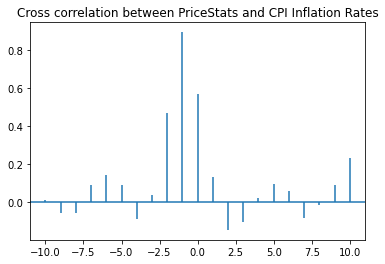

In [97]:
# Plotting cross-correlation of PriceStats inflation rate and CPI inflation rate 

plt.xcorr(pricestats_train.PriceStats_avg_rate[1:], cpi_train.IR[1:])
plt.title('Cross correlation between PriceStats and CPI Inflation Rates')
plt.show()

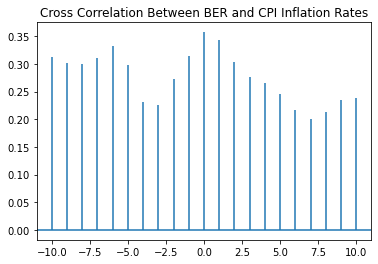

In [98]:
# Plotting cross-correlation of BER and CPI inflation rates

plt.xcorr(ber_train.BER_avg_rate[1:], cpi_train.IR[1:])
plt.title('Cross Correlation Between BER and CPI Inflation Rates')
plt.show()

From the first cross correlation plot we can see that there is strong correlation between CPI and PriceStats inflation rates with one lag (i.e. -1). This means when fitting the model, PriceStats should be shifted backwards by 1 lag. From the two external choices as regressors to predict CPI, PriceStats should provide better results as it correlates more with CPI than BER does. By looking at the correlation between BER and CPI inflation rates we see a correlation to a lesser extent most of the time and the peak at lag 0 and second highest peak at lag 6 (i.e. -6).

<b> Fit a new $\text {AR}$ model to the $\text {CPI}$ inflation rate with these external regressors and the most appropriate lag. Report the coefficients.</b>

In [99]:
# Preparing exogenous variables for fitting

exogenous = ber_train.copy()
exogenous.loc[2:, 'PriceStats_avg_rate'] = pricestats_train.drop([0]).PriceStats_avg_rate # Accounting for -1 lag
exogenous = exogenous.drop(['BER_m', 'YearMonth'], axis=1).drop([0,1]).values # dropping unwanted columns and NaN values
exogenous = np.array(exogenous, dtype=float) # numpy array float
exogenous.shape

(60, 2)

In [100]:
# Preparing endogenous variable for fitting

endogenous = cpi_train.IR.drop([0,1]).reset_index().drop(['index'], axis=1) # dropping rows to match same length
endogenous = np.array(endogenous, dtype=float).reshape(-1) # numpy array float
endogenous.shape

(60,)

In [101]:
# Fitting with SARIMAX (2,0,0) model

model_sarimax = sm.tsa.statespace.SARIMAX(endogenous, exogenous, order=(2,0,0), coerce_errors=True).fit(disp=False)

In [102]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -23.155
Date:                Mon, 21 Mar 2022   AIC                             56.310
Time:                        12:47:17   BIC                             66.782
Sample:                             0   HQIC                            60.406
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6299      0.464      1.359      0.174      -0.279       1.538
x2             0.2650      0.109      2.432      0.015       0.051       0.478
ar.L1          0.4421      0.126      3.495      0.000       0.194       0.690
ar.L2         -0.1450      0.141     -1.027      0.304      -0.422       0.132
sigma2         0.1263      0.021      5.914      0.000       0.084       0.168
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.41
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.80
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b> Report the mean squared prediction error for 1 month ahead forecasts.</b>

In [103]:
# Making predictions 1 month ahead

training_predictions_sarimax = model_sarimax.predict(start =2, end = 59, exog = exogenous)

k= 2
coef = model_sarimax.params
past = endogenous[len(endogenous)-k:]
past = [past[i] for i in range(k)]
test_predictions_sarimax = list()

past_ps = pricestats_train.PriceStats_avg_rate.values[-1] # since lag was 1 between CPI and PriceStats
pred = coef[3]*past[0] + coef[2]*past[1] + coef[1] * pricestats_train.PriceStats_avg_rate.values[-1] + coef[0] * ber_test.BER_avg_rate.iloc[0] 
test_predictions_sarimax.append(pred)
obs = cpi_test.IR.values[0]
past.append(obs)

for t in range(1,len(cpi_test.IR)):
    length = len(past)
    lag = [past[i] for i in range(length-2,length)]
    pred = coef[3]*lag[0] + coef[2]*lag[1] + coef[1] * pricestats_test.PriceStats_avg_rate.iloc[t-1] + coef[0] * ber_test.BER_avg_rate.iloc[t] 
    test_predictions_sarimax.append(pred)
    obs = cpi_test.IR.values[t]
    past.append(obs)

In [104]:
# Calculating the prediction error RMSE for the SARIMAX model

rmse_final = mean_squared_error(cpi_test.IR.values[:-2], test_predictions_sarimax[:-2], squared=False)
print("The mean squared prediction error of the final model is " + str(rmse_final))

The mean squared prediction error of the final model is 0.1986331078587314


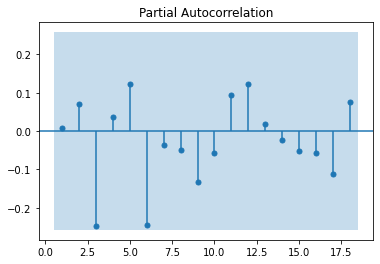

In [105]:
# Checking autocorrelation of residuals

residuals = (endogenous[2:] - training_predictions_sarimax)
plot_pacf(residuals, zero=False)
plt.show()

In [106]:
# Plotting predictions

p = figure(plot_width=800, plot_height=600, title = "CPI Predictions with SARIMAX (2,0,0)")
p.line(range(len(endogenous+2)), endogenous, line_width =2.5, line_color="lightgreen", line_dash="dashed", legend_label ="Training Data")
p.line(range(len(training_predictions_sarimax+2)), training_predictions_sarimax, line_color="green", line_width=2.5, legend_label ="Final Model (Training Data Fit)")
p.line(cpi_test.index ,cpi_test.IR, line_width =2.5, line_color="orange", line_dash="dashed", legend_label ="CPI")
p.line(cpi_test.index[:-1], test_predictions_sarimax[:-1], line_color="orangered", line_width=2.5, legend_label ="Final  Model Predictions")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.legend.location ='bottom_right'
show(p)

The results from the SARIMAX model are very good and by addding external regressor to predict the data we managed to achieve better results than previously when predicting only with the CPI itself. The errors on the RMSE and MAPE are low, the residuals are normal without a sign of autocorrelation, and from the plot we can see that the predictions follow quite nicely the training and testing data.

<b> What other steps can you take to improve your model? What is the smallest prediction error you can obtain? Describe the model that performs best. You might consider including MA terms, adding a seasonal AR term, or adding multiple daily values (or values from different months) of PriceStats and BER data as external regressors.</b>

In [107]:
# Fitting with SARIMAX (2,0,1) model

model_sarimax_2 = sm.tsa.statespace.SARIMAX(endogenous, exogenous, order=(2,0,1), coerce_errors=True).fit(disp=False)

In [108]:
model_sarimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -22.402
Date:                Mon, 21 Mar 2022   AIC                             56.804
Time:                        12:47:18   BIC                             69.370
Sample:                             0   HQIC                            61.720
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5942      0.181      3.274      0.001       0.238       0.950
x2             0.2751      0.124      2.219      0.026       0.032       0.518
ar.L1          1.3247      0.103     12.877      0.000       1.123       1.526
ar.L2         -0.4453      0.115     -3.870      0.000      -0.671      -0.220
ma.L1         -0.9999     36.204     -0.028      0.978     -71.959      69.959
sigma2         0.1190      4.293      0.028      0.978      -8.294       8.532
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.57
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.81
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
# Making predictions 1 month ahead

training_predictions_sarimax_2 = model_sarimax_2.predict(start =2, end = 59, exog = exogenous)

k= 2
coef = model_sarimax_2.params
past = endogenous[len(endogenous)-k:]
past = [past[i] for i in range(k)]
test_predictions_sarimax_2 = list()

past_ps = pricestats_train.PriceStats_avg_rate.values[-1] # Since lag was 1 between CPI and PriceStats
pred = coef[3]*past[0] + coef[2]*past[1] + coef[1] * pricestats_train.PriceStats_avg_rate.values[-1] + coef[0] * ber_test.BER_avg_rate.iloc[0] 
test_predictions_sarimax_2.append(pred)
obs = cpi_test.IR.values[0]
past.append(obs)

for t in range(1,len(cpi_test.IR)):
    length = len(past)
    lag = [past[i] for i in range(length-2,length)]
    pred = coef[3]*lag[0] + coef[2]*lag[1] + coef[1] * pricestats_test.PriceStats_avg_rate.iloc[t-1] + coef[0] * ber_test.BER_avg_rate.iloc[t] 
    test_predictions_sarimax_2.append(pred)
    obs = cpi_test.IR.values[t]
    past.append(obs)

In [110]:
# Calculating the prediction error RMSE for the second SARIMAX model

rmse_final = mean_squared_error(cpi_test.IR.values[:-2], test_predictions_sarimax_2[:-2], squared=False)
print("The mean squared prediction error of the final model is " + str(rmse_final))

The mean squared prediction error of the final model is 0.30142230929126157


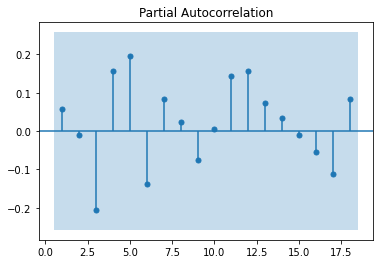

In [111]:
# Checking autocorrelation of residuals

residuals = (endogenous[2:] - training_predictions_sarimax_2)
plot_pacf(residuals, zero=False)
plt.show()

In [112]:
# Plotting predictions

p = figure(plot_width=800, plot_height=600, title = "CPI Predictions with SARIMAX (2,0,1)")
p.line(range(len(endogenous+2)), endogenous, line_width =2.5, line_color="lightgreen", line_dash="dashed", legend_label ="Training Data")
p.line(range(len(training_predictions_sarimax_2+2)), training_predictions_sarimax_2, line_color="green", line_width=2.5, legend_label ="Final Model (Training Data Fit)")
p.line(cpi_test.index ,cpi_test.IR, line_width =2.5, line_color="orange", line_dash="dashed", legend_label ="CPI")
p.line(cpi_test.index[:-1], test_predictions_sarimax_2[:-1], line_color="orangered", line_width=2.5, legend_label ="Final  Model Predictions")
p.xaxis.ticker = [0, 35, 70, 105, 140]
p.xaxis.major_label_overrides = {0: '2008', 35: '2011', 70: '2014', 105: '2017', 140: '2020'}
p.legend.location ='bottom_right'
show(p)

We could see from the cross correlation plots that the lag extends to two periods in the past and extending beyond this, the variables do not correlate anymore, and thus we shouldn't expect to gain more predictive power by adding any more lag components to the model. The CPI also doesn't show any seasonality so this option is also excluded from the options. We could try to add some other components to the model like a moving average, but as we can see from the results, the prediction doesn't get any better: now the model becomes too caucious in fitting the model and the opposite in the predictions. By increasing the number of components the results get even worse so the only way to actually improve the model would be to get some other external regressors (i.e. more data) that would correlate well with the CPI in such a away that it would help to predict the forecast of CPI even better than what we have achieved now.